This is a tutorial for basic use of abides_markets simulation.
It uses the simulator directly without the OpenAI Gym interface

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import rmsc05

## Build runnable configuration

Here we are generating/building a config from the config file rmsc04. 
The config object is a dictionnary containing key elements like, start time, end time, agents to be used, latency and computation delay models.

In [2]:
config = rmsc05.build_config(
    end_time="13:00:00"
)

In [3]:
config.keys()

dict_keys(['seed', 'start_time', 'stop_time', 'agents', 'agent_latency_model', 'default_computation_delay', 'custom_properties', 'random_state_kernel', 'stdout_log_level'])

## Running simulation

Once the config is ready it can be run using the abides runner function.
It instanciates a simulation kernel, runs the configuration and returns an end_state that mostly contains pointers to the different agent objects.
The agents are in their final state, their internal variables can be accessed to extract informations of interests like logs.

In [4]:
end_state = abides.run(config)

[62635] INFO abides Simulation Start Time: 2022-10-25 14:45:26.046887
[62635] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[62635] INFO abides_core.kernel --- Simulation time: 2021-02-05 10:54:40, messages processed: 100,000, wallclock elapsed: 9.28s ---
[62635] INFO abides_core.kernel --- Simulation time: 2021-02-05 12:27:43, messages processed: 200,000, wallclock elapsed: 20.16s ---
[62635] INFO abides_core.kernel Event Queue elapsed: 0:00:23.314187, messages: 231,126, messages per second: 9913.5
[62635] INFO abides_core.kernel Mean ending value by agent type:
[62635] INFO abides_core.kernel NoiseAgent: -238
[62635] INFO abides_core.kernel ValueAgent: 120889
[62635] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: 273678
[62635] INFO abides_core.kernel MomentumAgent: -1053340
[62635] INFO abides_core.kernel Simulation ending!
[62635] INFO abides Simulation End Time: 2022-10-25 14:45:53.443216
[62635] INFO ab

## Retrieving results from end_state

By convention in abides_markets configuration the first agent is the exchange agent. 
It contains an order_book. By default it logs its history.

In [5]:
order_book = end_state["agents"][0].order_books["ABM"]

### Order book history L1

L1 data snapshots for every tick can be extracted
( best bid and ask price and quantity )

In [8]:
L1 = order_book.get_L1_snapshots()

Here we plot the time series of the best bid and best ask price thoughout the simulation

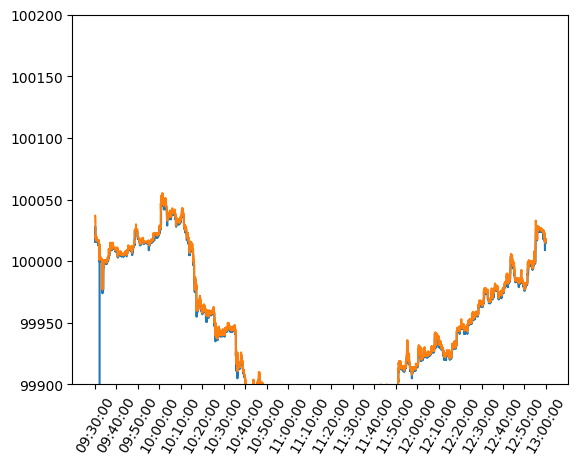

In [9]:
best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])

## All times are in ns from 1970, remove the date component to put them in ns from midnight
best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )

plt.plot(best_bids.time,best_bids.price)
plt.plot(best_asks.time,best_asks.price)

band = 100
plt.ylim(100_000-band,100_100+band)

time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns("13:10:00"),
    1e9*60*10
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

### Order book history L2

L2 data snapshots for every tick can be extracted
( bids and asks price and quantity for every orderbook level. Here max depth logged is a parameter of the simulation and max number of levels we want to retrieve from the orderbook after the simulation is a parameter too)

In [6]:
L2 = order_book.get_L2_snapshots(nlevels=10)

As an illustration we plot the time series of the fifth best bid price and fifth best ask price throughout the simulation

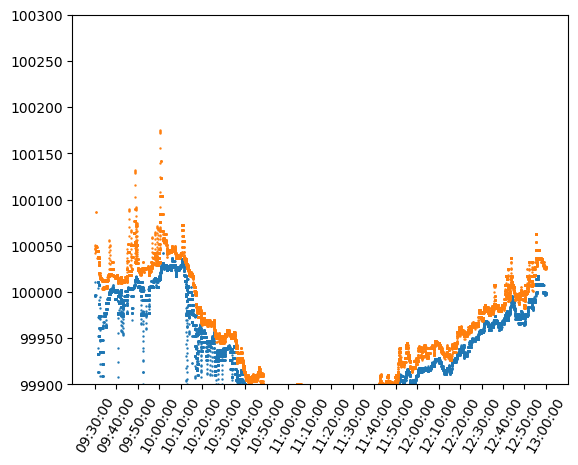

In [10]:
## plotting fifth best bid and fifth best ask
times = [ t - ns_date(t) for t in L2["times"] ]
plt.scatter( times, L2["bids"][:,5,0], s=.5 )
plt.scatter( times, L2["asks"][:,5,0], s=.5 )

band = 100
plt.ylim(100_000-band,100_200+band)

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

### Looking at agents logs

All agents can be inspected to retrieve desired information. 
The utility parse_logs_df for instance provides a quick way to retrieve and aggregate the log variables of each agent in a single dataframe

In [11]:
logs_df = parse_logs_df( end_state )

#### Histogram of order submission times for noise agents

As an illustration we retrieve the submission times of all the orders sent by noise agent and display the histogram of all these times

In [ ]:
plt.hist( logs_df[ (logs_df.agent_type == "NoiseAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )


We proceed the same way for value agents as well

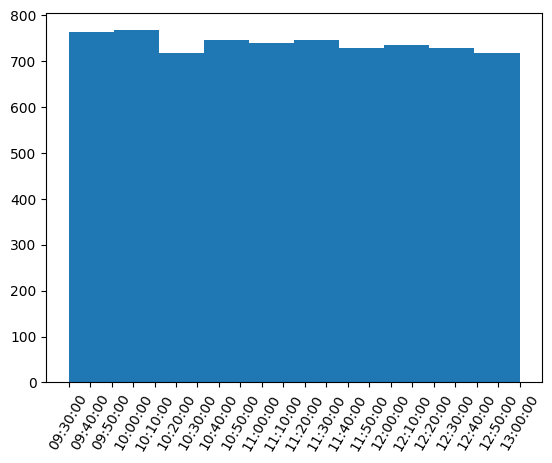

In [88]:
plt.hist( logs_df[ (logs_df.agent_type == "ValueAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [ ]:
plt.hist( logs_df[ (logs_df.agent_type == "MomentumAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [ ]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df

In [ ]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df_start = df.loc[df['EventType'] == 'STARTING_CASH']
df_start = df_start[['agent_id', 'ScalarEventValue']]
df_end = df.loc[df['EventType'] == 'ENDING_CASH']
df_end = df_end[['agent_id', 'ScalarEventValue']]
df = pd.merge(df_start[['agent_id', 'ScalarEventValue']],
                df_end[['agent_id', 'ScalarEventValue']],
                how='left',
                left_on=['agent_id'],
                right_on=['agent_id'],
                suffixes=['_Open',
                         '_Close'])
df['diff'] = df['ScalarEventValue_Open'] - df['ScalarEventValue_Close']

df


In [ ]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df = df.loc[df['EventType'] == 'MARKED_TO_MARKET']

df

# Plotting

In [12]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
#df = logs_df.loc[logs_df['EventType'] == 'MARKET_FEE']

total_fee = df['fee'].sum()
print(round(total_fee / 100, 2))

In [ ]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df = df.loc[df['EventType'] == 'ORDER_EXECUTED']

df.to_csv('order_executed.csv')

# orderbook plotting

In [ ]:
L2 = order_book.get_L2_snapshots(nlevels=10)

In [ ]:
time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns("13:10:00"),
    1e9*60*10
)

## plotting fifth best bid and fifth best ask
times = [ t - ns_date(t) for t in L2["times"] ]
plt.scatter( times, L2["bids"][:,5,0], s=.5 )
plt.scatter( times, L2["asks"][:,5,0], s=.5 )

band = 100
plt.ylim(100_000-band,100_200+band)

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [ ]:

times[1]


In [ ]:

times = [ t - ns_date(t) for t in L2["times"] ]

fmt_ts(times[2]).split(" ")[1]

In [ ]:


trace1 = {
  "mode": "lines+markers", 
  "name": "bid", 
  "type": "scatter", 
  "x": [4277.5, 4269.81, 4269.79, 4269.77, 4268.31, 4268.26, 4267.69, 4265.99, 4264.27, 4261.72, 4261.71, 4260.29, 4259.83, 4258.0, 4257.99, 4256.06, 4256.05, 4255.93, 4254.93, 4253.93, 4253.3, 4252.93, 4251.93, 4251.62, 4251.6, 4251.39, 4250.0, 4249.72, 4249.34, 4249.27, 4248.76, 4247.28, 4245.01, 4245.0, 4243.59, 4243.14, 4243.06, 4243.0, 4242.42, 4242.22, 4242.0, 4241.0, 4240.82, 4240.69, 4240.0, 4239.47, 4238.4, 4237.84, 4234.35, 4234.33, 4233.87, 4233.01, 4232.08, 4231.05, 4231.0, 4230.0, 4228.0, 4227.63, 4227.0, 4226.33, 4225.83, 4223.47, 4222.36, 4220.77, 4220.0, 4218.32, 4216.1, 4216.0, 4215.0, 4214.83, 4214.01, 4214.0, 4211.95, 4211.76, 4211.0, 4210.43, 4210.0, 4209.84, 4209.28, 4209.07, 4208.08, 4208.0, 4207.21, 4206.59, 4206.19, 4206.01, 4206.0, 4205.01, 4205.0, 4204.0, 4203.32, 4203.28, 4202.0, 4201.11, 4201.0, 4200.54, 4200.44, 4200.1, 4200.0, 4199.0], 
  "y": [0.16494892, 1.03644892, 1.95246386, 2.66559095, 6.16209095, 11.305403949999999, 11.43860395, 16.471803949999998, 22.03278893, 25.554172219999998, 31.254172219999997, 36.29417222, 36.45887222, 36.768872220000006, 41.768872220000006, 41.82887222000001, 47.62497222000001, 48.55997222000001, 49.494972220000015, 55.666764930000014, 55.68676493000002, 56.62176493000002, 57.55776493000002, 64.55076493000001, 69.49598893000001, 70.25653313000001, 76.06407684000001, 76.11407684000001, 76.11596699, 81.15926699, 131.20926699, 136.16798303000002, 142.16798303000002, 146.16798303000002, 146.16987317000002, 146.17769756, 151.68309756000002, 153.57568349000002, 157.81810349000003, 157.96520349000002, 159.96520349000002, 161.96520349000002, 167.62086549000003, 173.76306984, 173.77076994, 174.37035508, 180.37035508, 180.37224521, 181.39718520999998, 183.27453418999997, 183.37751561999997, 185.22751561999996, 185.22941573999995, 189.22941573999995, 195.22941573999995, 195.84780225999995, 222.17826109999996, 272.22826109999994, 272.27878740999995, 272.33068751999997, 272.37068752, 274.39020707, 284.63960706999995, 284.64240706999993, 284.6642886099999, 284.6699476099999, 284.7949476099999, 285.6205476099999, 288.5008040899999, 288.5027043899999, 288.6527043899999, 289.21370438999986, 289.21560528999987, 289.61560528999985, 289.77960528999984, 289.7845085299998, 289.9336653199998, 290.0238492699998, 290.2738492699998, 290.2757495599998, 290.3757495599998, 290.4418969299998, 290.4518969299998, 340.5018969299998, 340.5037978199998, 349.83427515999983, 349.93027515999984, 351.3005648299998, 351.8505648299998, 351.99656482999984, 351.9984651099998, 352.0184651099998, 352.0864651099998, 352.48646510999976, 353.3996995099998, 353.4398857399998, 353.4417866199998, 353.71178661999977, 359.70532410999976, 359.71032410999976]
}
trace2 = {
  "mode": "lines+markers", 
  "name": "ask", 
  "type": "scatter", 
  "x": [4277.51, 4279.98, 4279.99, 4280.0, 4282.0, 4282.9, 4285.32, 4286.61, 4287.0, 4289.0, 4289.43, 4289.58, 4289.6, 4289.98, 4290.0, 4290.01, 4290.12, 4290.51, 4291.14, 4291.36, 4291.99, 4292.0, 4293.02, 4293.45, 4293.65, 4294.65, 4295.05, 4295.61, 4297.0, 4297.03, 4298.2, 4298.34, 4298.58, 4298.77, 4298.93, 4299.0, 4299.84, 4299.85, 4299.99, 4300.0, 4301.16, 4302.0, 4302.47, 4303.1, 4304.4, 4304.42, 4304.53, 4304.96, 4305.26, 4305.27, 4306.0, 4306.58, 4307.51, 4307.58, 4307.99, 4308.0, 4308.43, 4308.77, 4309.0, 4309.09, 4310.0, 4310.28, 4311.09, 4312.0, 4312.14, 4312.8, 4312.82, 4313.0, 4313.15, 4313.43, 4313.52, 4313.74, 4314.0, 4315.0, 4315.12, 4316.0, 4316.03, 4316.22, 4316.46, 4316.73, 4316.8, 4317.0, 4318.0, 4318.4, 4318.52, 4319.0, 4319.12, 4319.7, 4319.75, 4320.0, 4320.13, 4321.78, 4321.98, 4322.0, 4322.25, 4322.44, 4324.0, 4324.18, 4324.78, 4324.94], 
  "y": [0.04088894, 0.19953454000000004, 2.6199855100000002, 101.37344861, 113.07709238, 118.92479238, 124.42479238, 129.61479238, 129.6705871, 130.03058710000002, 130.03175509000002, 132.64625509, 138.87997009, 142.37647009, 242.37647009, 242.38348921, 242.52778920999998, 243.55272920999997, 249.25272920999996, 299.25272921, 299.28272920999996, 303.25561182999996, 303.25750199, 303.25939291, 308.69779291, 319.98057590999997, 325.79057591, 330.61027591, 330.81027591, 330.86027591, 335.66027591, 335.66213479, 335.66916326, 335.67104343, 335.83224343, 336.93224343, 337.04344343, 337.34344343000004, 342.25857843000006, 344.9207383500001, 344.9277672900001, 345.2277672900001, 350.4277672900001, 350.4297672900001, 356.0297672900001, 356.04234687000013, 356.04422705000013, 356.04611799000014, 360.05073823000015, 360.0807382300001, 360.0928436200001, 365.3928436200001, 365.39411918000013, 365.41313239000016, 365.41440742000015, 365.8604074200002, 365.86226194000017, 365.88152498000017, 366.88152498000017, 372.53152498000014, 376.1595249800001, 376.16140517000014, 381.5614051700001, 381.9074051700001, 381.91294706000014, 388.90594706000013, 438.90594706000013, 439.0151484200001, 439.11514842000014, 445.11514842000014, 445.13439025000014, 445.31439025000014, 445.36039025000014, 445.45824370000014, 445.6582437000001, 448.1833782800001, 448.18525848000013, 448.24877824000015, 448.25065920000014, 448.26941737000016, 448.32422419000017, 448.3742241900002, 448.42022419000017, 450.44860650000015, 450.4504566900002, 450.5004566900002, 450.5179896600002, 450.5279896600002, 451.0279896600002, 474.10635320000017, 474.38038866000016, 474.38225887000016, 474.88225887000016, 475.48825887000015, 485.73765887000013, 485.7585956300001, 485.8045956300001, 485.90459563000013, 485.95459563000014, 486.15459563000013]
}
data = go.Data([trace1, trace2])

layout = {
  "title": "Limited Order Book", 
  "xaxis": {"title": "price"}, 
  "yaxis": {"title": "amount"}
}
fig = go.Figure(data=data, layout=layout)

fig


In [ ]:
L2["bids"][100][1][0]

In [ ]:
L2["bids"][100]

In [ ]:
def appendDictToDF(df,dictToAppend):
  df = pd.concat([df, pd.DataFrame.from_records([dictToAppend])])
  return df

In [ ]:


# get the volume of the 100th bid

bid_price = []
for i in range(0, len(L2["bids"][100])):
    bid_price.append(L2["bids"][100][i][0]/100)

bid_vol = []
for i in range(0, len(L2["bids"][0])):
    bid_vol.append(L2["bids"][100][i][1])

bid_vol = np.cumsum(bid_vol)

ask_price = []
for i in range(0, len(L2["asks"][0])):
    ask_price.append(L2["asks"][100][i][0]/100)

ask_vol = []
for i in range(0, len(L2["asks"][0])):
    ask_vol.append(L2["asks"][100][i][1])

ask_vol = np.cumsum(ask_vol)


In [ ]:
for i in range(0, 10):
            df = appendDictToDF(df, {
                'lvl': i,
                'nanoseconds': time,
                'bid_vol_cumsum': 4,
                'bid_price': 4,
                'ask_vol_cumsum': 4,
                'ask_price': 4
            })

In [ ]:
arr = np.array([2, 7, 5, 8, 9,4])
arr1 = np.cumsum(arr)[5]

arr1

In [87]:
times = [ t - ns_date(t) for t in L2["times"] ]

values = []
for x in range(0, len(times)):
    bid_vol = []
    ask_vol = []
    for i in range(0, 10):
        bid_vol.append(L2["bids"][x][i][1])
        ask_vol.append(L2["asks"][x][i][1])
        values.append({
            'lvl': i+1,
            'nanoseconds': times[x],
            'bid_vol_cumsum': np.cumsum(bid_vol)[i],
            'bid_price': L2["bids"][x][i][0]/100,
            'ask_vol_cumsum': np.cumsum(ask_vol)[i],
            'ask_price': L2["asks"][x][i][0]/100
        })


df = pd.DataFrame(values)
df[500:510]


,lvl,nanoseconds,bid_vol_cumsum,bid_price,ask_vol_cumsum,ask_price
500,1,3.422371e+13,100,1000.16,1000,1000.20
501,2,3.422371e+13,104,1000.08,1104,1000.21
502,3,3.422371e+13,108,999.42,1504,1000.33
503,4,3.422371e+13,112,998.76,1604,1000.37
504,5,3.422371e+13,116,998.10,1704,1000.44
505,6,3.422371e+13,120,997.44,1804,1000.49
506,7,3.422371e+13,124,996.78,1808,1000.87
507,8,3.422371e+13,128,996.12,1810,1001.53
508,9,3.422371e+13,132,995.46,1812,1002.19
509,10,3.422371e+13,136,994.80,1814,1002.85


# test

# Orderbook Depth Plot

In [89]:
times = [ t - ns_date(t) for t in L2["times"] ]
tt = []
for t in times:
    if(t in tt):
       continue
    else:
        tt.append(t)


values = []
for x in range(0, len(tt)):
    bid_vol = []
         

    v1 = {'axes': 0, 'trial': 0, 'timepoint': tt[x], 'vol': 0, 'price': L2["bids"][x][0][0]/100}
    values.append(v1)

    for i in range(0, 10):
        bid_vol.append(L2["bids"][x][i][1])
        v1 = {'axes': 0, 'trial': 1+i, 'timepoint': tt[x], 'vol': np.cumsum(bid_vol)[i], 'price': L2["bids"][x][i][0]/100}
        values.append(v1)


    v2 = {'axes': 1, 'trial': 11, 'timepoint': tt[x], 'vol': 0, 'price': L2["asks"][x][0][0]/100}
    values.append(v2)

    ask_vol = []
    for z in range(0,10):
        ask_vol.append(L2["asks"][x][z][1])
        v2 = {'axes': 1, 'trial': 12+z, 'timepoint': tt[x], 'vol': np.cumsum(ask_vol)[z], 'price': L2["asks"][x][z][0]/100}
        values.append(v2)
   
        

df = pd.DataFrame(values)

orderbook = (px.line(df[0:10000], x='price', y='vol', animation_frame='timepoint', animation_group='timepoint', color='axes', range_y=[0, 2000], height=600, width=800, title='Orderbook'))
orderbook